In [96]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'large'
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 6),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)

from nbodykit.lab import cosmology

import scipy
from scipy import optimize
import pandas as pd

import george
from george import kernels

In [2]:
boxsize = 750
nbar_str = '3e-4'
seed = 0
cat_tag = '_L{}_nbar{}'.format(boxsize, nbar_str)
cat_dir = '../catalogs/cats_lognormal{}'.format(cat_tag)

In [3]:
data_fn = '{}/cat_lognormal{}_seed{}.dat'.format(cat_dir, cat_tag, seed)
data = np.loadtxt(data_fn)
#nd = data.shape[0]
datasky_fn = '{}/catsky_lognormal{}_seed{}.dat'.format(cat_dir, cat_tag, seed)
datasky = np.loadtxt(datasky_fn).T
datadf = pd.DataFrame(data, columns=['x','y','z'])

In [432]:
rand_fn = '{}/rand{}_10x.dat'.format(cat_dir, cat_tag)
random = np.loadtxt(rand_fn)
#nr = random.shape[0]
randsky_fn = '{}/randsky{}_10x.dat'.format(cat_dir, cat_tag)
randomsky = np.loadtxt(randsky_fn)
randdf = pd.DataFrame(random, columns=['x','y','z'])

In [29]:
nsys = 2
sys_names = ['s0', 's1']
sys_labels = ['systematic 1', 'systematic 2']
npixside = 20
mask = np.zeros((nsys, npixside, npixside))
pixarea = (boxsize/npixside)**2

In [5]:
def normalize(w):
    wmin = min(w)
    wspread = max(w) - min(w)
    return (w-wmin)/wspread

In [6]:
def sys0(i, j):
    return np.random.random()

def sys1(i, j):
    ijmax = npixside*npixside
    return i*j/ijmax

In [124]:
def plot_nratio(df, res=None, gppred=None):
    nbartot = len(df)/(boxsize**2)
    sfine = np.linspace(0, 1)
    
    fig, axarr = plt.subplots(nrows=1, ncols=nsys, figsize=(7*nsys, 5))
    
    fits = []
    if gppred is not None:
        fits_grid = np.zeros((len(sfine), len(sfine)))
        for ii in range(len(sfine)):
            for jj in range(len(sfine)):
                stest = np.array([[sfine[ii], sfine[jj]]])
                fit = gppred(stest)
                fits_grid[ii][jj] = fit
        for k in range(nsys):
            fits.append(np.mean(fits_grid, axis=k))         

    #stest = np.array([sfine]).T
    #fits = [gppred(stest)]


    
    for k in range(nsys):
        ax = axarr[k]
        
        ss = []
        nratios = []
        weights_lin = []
        weights_gp = []
        for i in range(npixside):
            for j in range(npixside):
                sdf = df[(df['maski']==i) & (df['maskj']==j)]
                ngal = len(sdf)
                nbar = ngal/pixarea
                nratio = nbar/nbartot
                nratios.append(nratio)
                s = mask[k,i,j]
                ss.append(s)
                if res is not None:
                    weights_lin.append(weight_linear(res, i, j))
                
                if gppred is not None:
                    stest = np.array([mask[0:nsys,i,j]])
                    weights_gp.append(1./gppred(stest)[0])
                
        nratios = np.array(nratios)
        notrend = ax.axhline(1, ls='-', color='grey', lw=2, label='No trend')

        #ax.figure(figsize=(8,6))
        ax.set_xlabel(sys_labels[k])
        ax.set_ylabel(r'$\bar{n}/\bar{n}_{tot}$')

        alpha = 0.15
        lw = 3
        size = 15
        
        uncorr_mark = ax.scatter(ss, nratios, marker='+', ls='None', color='k', alpha=alpha, s=size)

        #hist, bin_edges = np.histogram(nratios)
        #plt.plot(bin_centers, hist, color='k')
        bin_edges = np.linspace(min(ss), max(ss), 16)
        bin_centers = 0.5*(bin_edges[:-1]+bin_edges[1:])
        bin_means = []
        for bb in range(len(bin_edges)-1):
            nratio_inbin = [nratios[m] for m in range(len(nratios)) if bin_edges[bb]<=ss[m]<bin_edges[bb+1]]
            bin_means.append(np.mean(nratio_inbin))
        
        uncorr_line, = ax.plot(bin_centers, bin_means, color='k', lw=lw, label='Uncorrected', ls='--')
                
        sfine = np.linspace(min(ss), max(ss))
        #sfines.append(sfine)
        if res is not None:
            fit = res.x[k] * (sfine - smeans[k])/sstds[k] + res.x[-1]
            #plt.plot(sfine, fit, color='magenta')

            nratios_weighted = nratios*weights_lin
            lin_mark = ax.scatter(ss, nratios_weighted, marker='o', s=size, ls='None', color='red', alpha=alpha)

            bin_means_weighted = []
            for bb in range(len(bin_edges)-1):
                nratio_weighted_inbin = [nratios_weighted[m] for m in range(len(nratios)) if bin_edges[bb]<=ss[m]<bin_edges[bb+1]]
                bin_means_weighted.append(np.mean(nratio_weighted_inbin))
            lin_line, = ax.plot(bin_centers, bin_means_weighted, color='red', lw=lw, ls='-.', label='Linear')     


        if gppred is not None:

            #plt.plot(sfine, fits[k], color='magenta')

            nratios_weighted = nratios*weights_gp
            ax.scatter(ss, nratios_weighted, marker='d', s=size, ls='None', color='blue', alpha=alpha)

            bin_means_weighted = []
            for bb in range(len(bin_edges)-1):
                nratio_weighted_inbin = [nratios_weighted[m] for m in range(len(nratios)) if bin_edges[bb]<=ss[m]<bin_edges[bb+1]]
                bin_means_weighted.append(np.mean(nratio_weighted_inbin))
            ax.plot(bin_centers, bin_means_weighted, color='blue', lw=lw, ls='-', label='Gaussian Process')    
            
        if k==nsys-1:
            #ax.legend([uncorr_line, lin_line, gp_line], ['uncorrected', 'linear'])
            ax.legend()
    
            

In [8]:
def linear_fit(params, mask, df, smeans, sstds):

    chi2 = 0
    avals = params[:-1]
    nk = len(avals)
    b = params[-1]
    
    nbartot = len(df)/(boxsize**2)
    for i in range(npixside):
        for j in range(npixside):

            ngal = len(df[(df['maski']==i) & (df['maskj']==j)])
            nbar = ngal/pixarea
            nratio = nbar/nbartot
            for k in range(nk):
                s = mask[k, i, j]
                wpinv = avals[k] * (s - smeans[k])/sstds[k] + b
                chi2 += (nratio - wpinv)**2

    return chi2

In [9]:
def compute_means(mask):
    smeans = []
    sstds = []
    for k in range(nsys):
        svals = []
        for i in range(npixside):
            for j in range(npixside):
                svals.append(mask[k, i, j])
        smeans.append(np.mean(svals))
        sstds.append(np.std(svals))
    return smeans, sstds

In [30]:
for i in range(npixside):
    for j in range(npixside):
        mask[0,i,j] = sys0(i,j)
        mask[1,i,j] = sys1(i,j)

In [31]:
smeans, sstds = compute_means(mask)
print(smeans)
print(sstds)

[0.4957715886270681, 0.225625]
[0.28976722736275884, 0.21076034227292384]


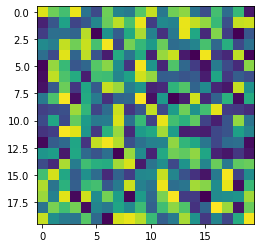

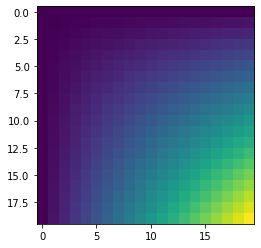

In [32]:
for i in range(nsys):
    plt.figure()
    plt.imshow(mask[i])

In [33]:
def xyz2ij(x,y,z):
    pixsize = boxsize/npixside
    i = np.floor(x/pixsize)
    j = np.floor(y/pixsize)
    i = [int(ii) for ii in i]
    j = [int(jj) for jj in j]
    return i,j

In [34]:
datadf['maski'], datadf['maskj'] = xyz2ij(datadf['x'], datadf['y'], datadf['z'])

In [35]:
datadf['s0'] = mask[0, datadf['maski'], datadf['maskj']]
datadf['s1'] = mask[1, datadf['maski'], datadf['maskj']]

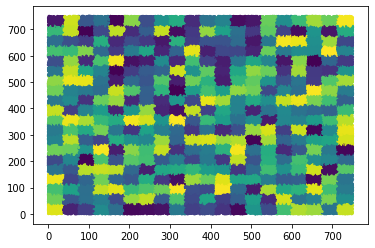

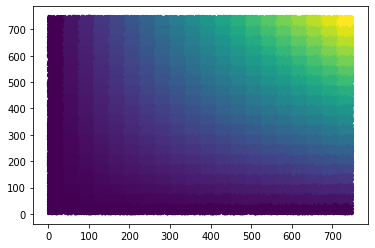

In [36]:
plt.figure()
plt.scatter(datadf['x'], datadf['y'], s=4, c=datadf['s0'])
plt.figure()
plt.scatter(datadf['x'], datadf['y'], s=4, c=datadf['s1'])

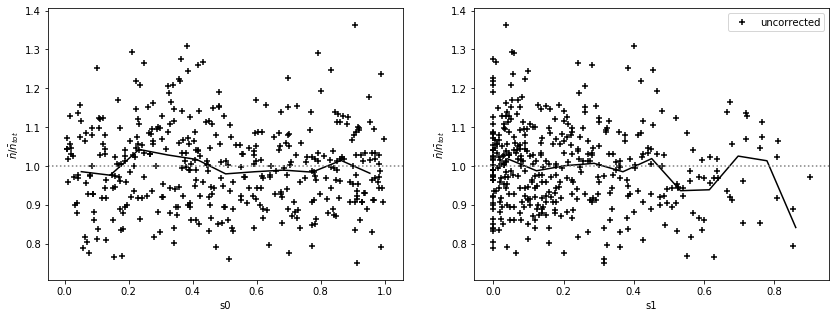

In [37]:
plot_nratio(datadf)

In [38]:
guess = [0]*nsys + [1]
print(guess)
args = (mask, datadf, smeans, sstds)
res = optimize.minimize(linear_fit, guess, args=args)
print(res.x)

[0, 0, 1]
[-0.00438941 -0.01223561  0.99999999]


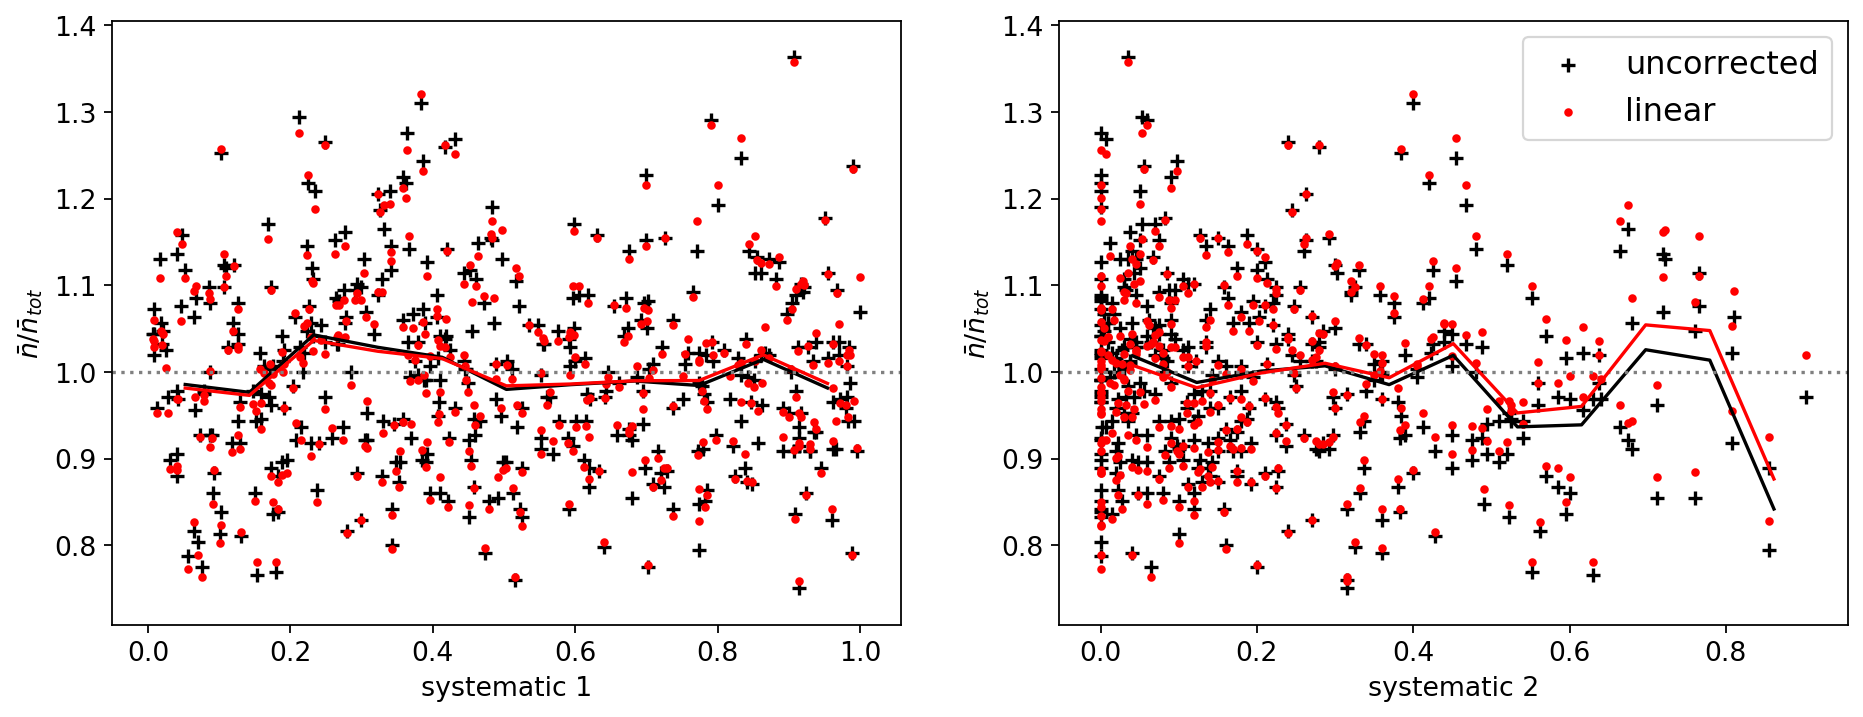

In [48]:
plot_nratio(datadf, res=res)

### Downsample - linear

In [148]:
# def weight_lin(res, df):
#     wpinv = res.x[-1] # b intercept
#     for k in range(nsys):
#         s = df[sys_names[k]]
#         wpinv += res.x[k] * (s - smeans[k])/sstds[k]
#     return 1.0/wpinv

In [49]:
def weight_linear(res, i, j):
    wpinv = res.x[-1] # b intercept
    for k in range(nsys):
        s = mask[k,i,j]
        wpinv += res.x[k] * (s - smeans[k])/sstds[k]
    return 1.0/wpinv

In [50]:
def linear(x):
    return 1-0.25*x

In [51]:
def downsample(ddf, weight_name, downfunc):
    sel = [np.random.random() for _ in range(len(ddf))]
    ww = downfunc(ddf[weight_name])
    subdf = ddf[sel < ww]
    return subdf

In [52]:
datadf['s01'] = 0.5*datadf['s0']+0.5*datadf['s1']# + 2*datadf['s0']*datadf['s1']
lindf = downsample(datadf, 's01', downfunc=linear)
print(len(lindf)/len(datadf))

0.9101158264502042


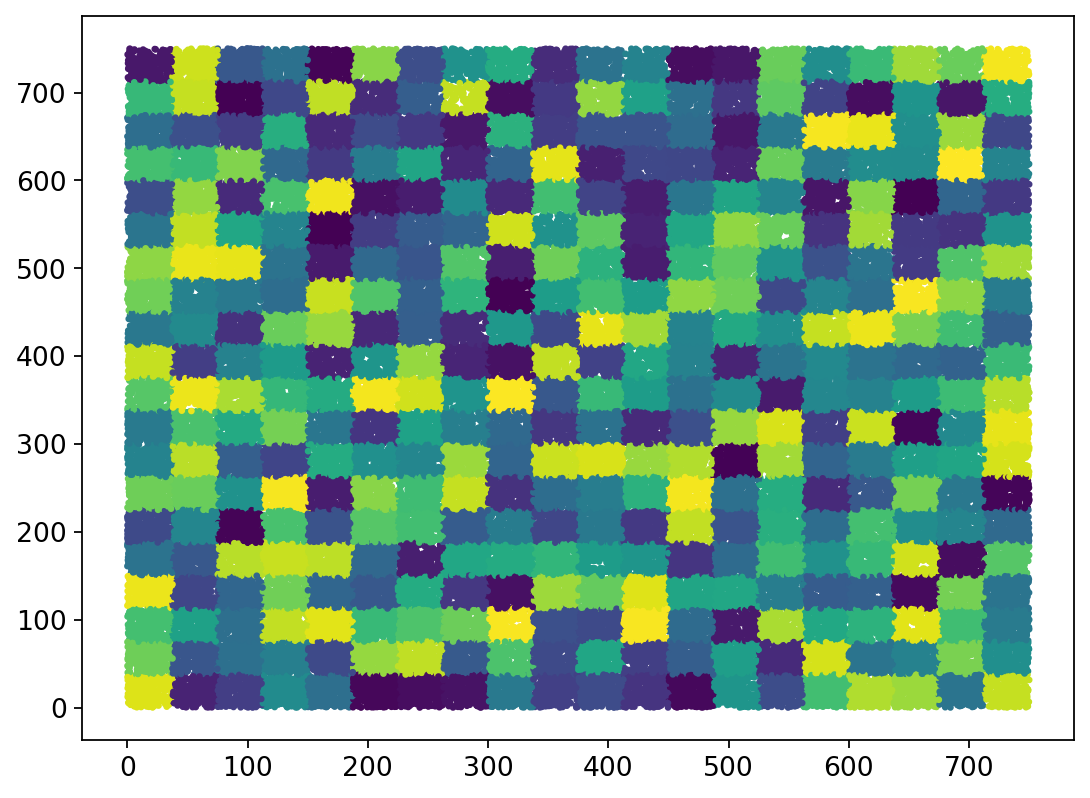

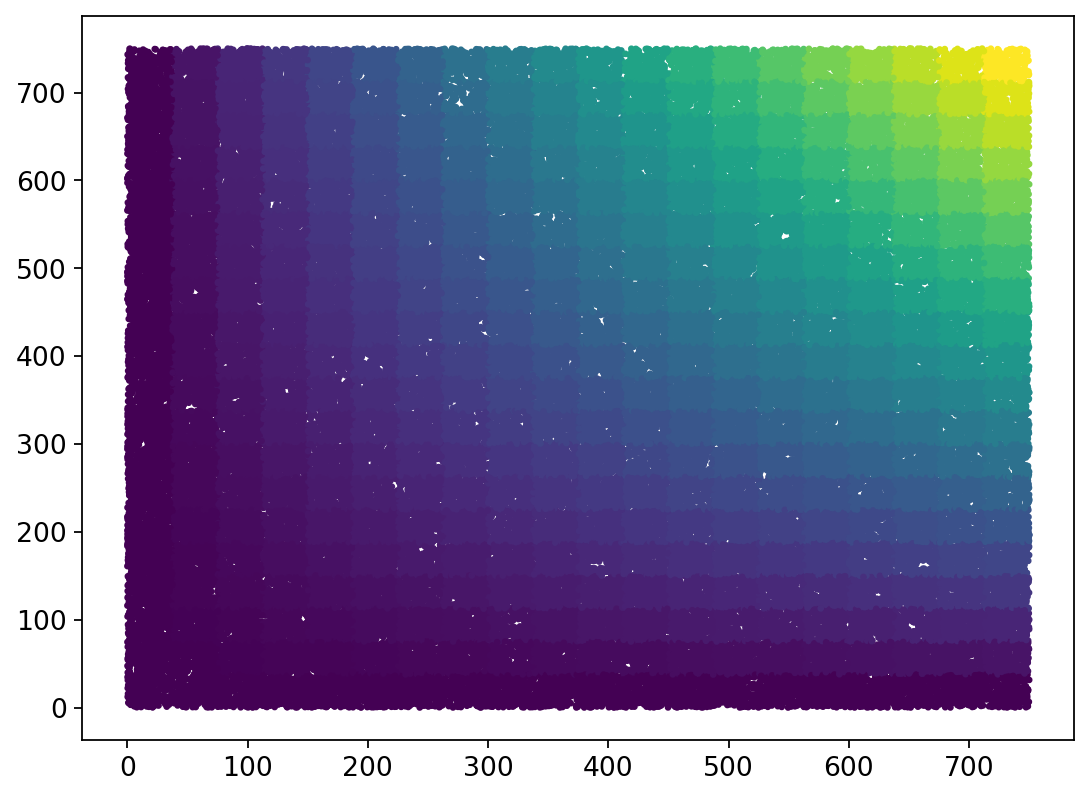

In [53]:
plt.figure()
plt.scatter(lindf['x'], lindf['y'], s=4, c=lindf['s0'])
plt.figure()
plt.scatter(lindf['x'], lindf['y'], s=4, c=lindf['s1'])

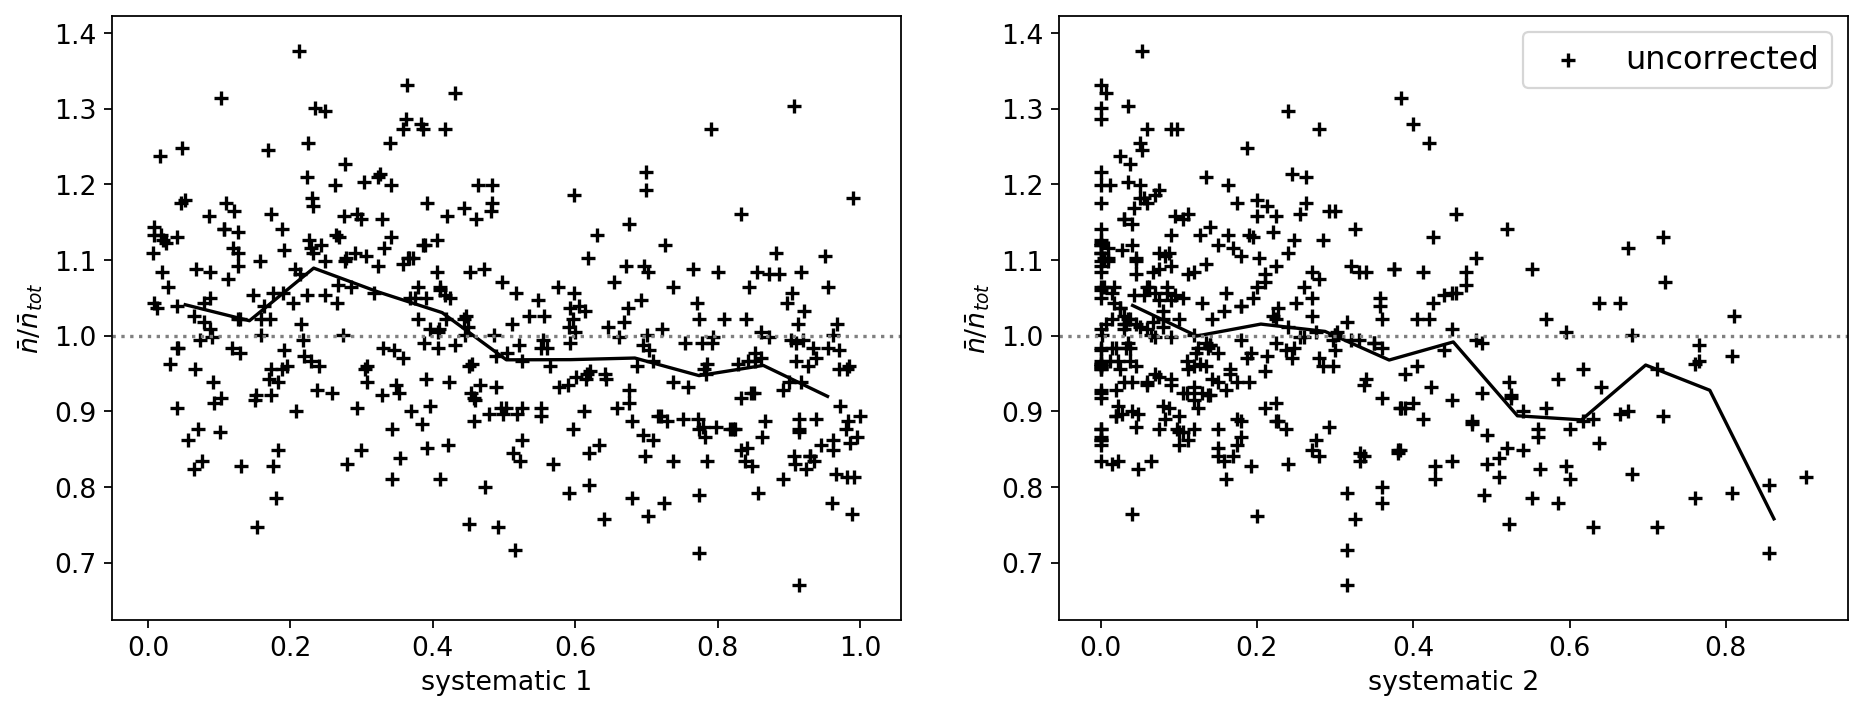

In [54]:
plot_nratio(lindf)

In [55]:
smeans, sstds = compute_means(mask)

In [56]:
guess = [0]*nsys + [1]
print(guess)
args = (mask, lindf, smeans, sstds)
res = optimize.minimize(linear_fit, guess, args=args)
print(res.x)

[0, 0, 1]
[-0.04467301 -0.03958555  0.99999999]


In [58]:
#lindf['wlin'] = weight_lin(res, lindf)

In [59]:
# plt.figure()
# plt.scatter(lindf['x'], lindf['y'], s=4, c=lindf['wlin'])
# plt.colorbar()

In [70]:
gpp_lin = gp_fit(mask, lindf, smeans, sstds)

(400, 2)


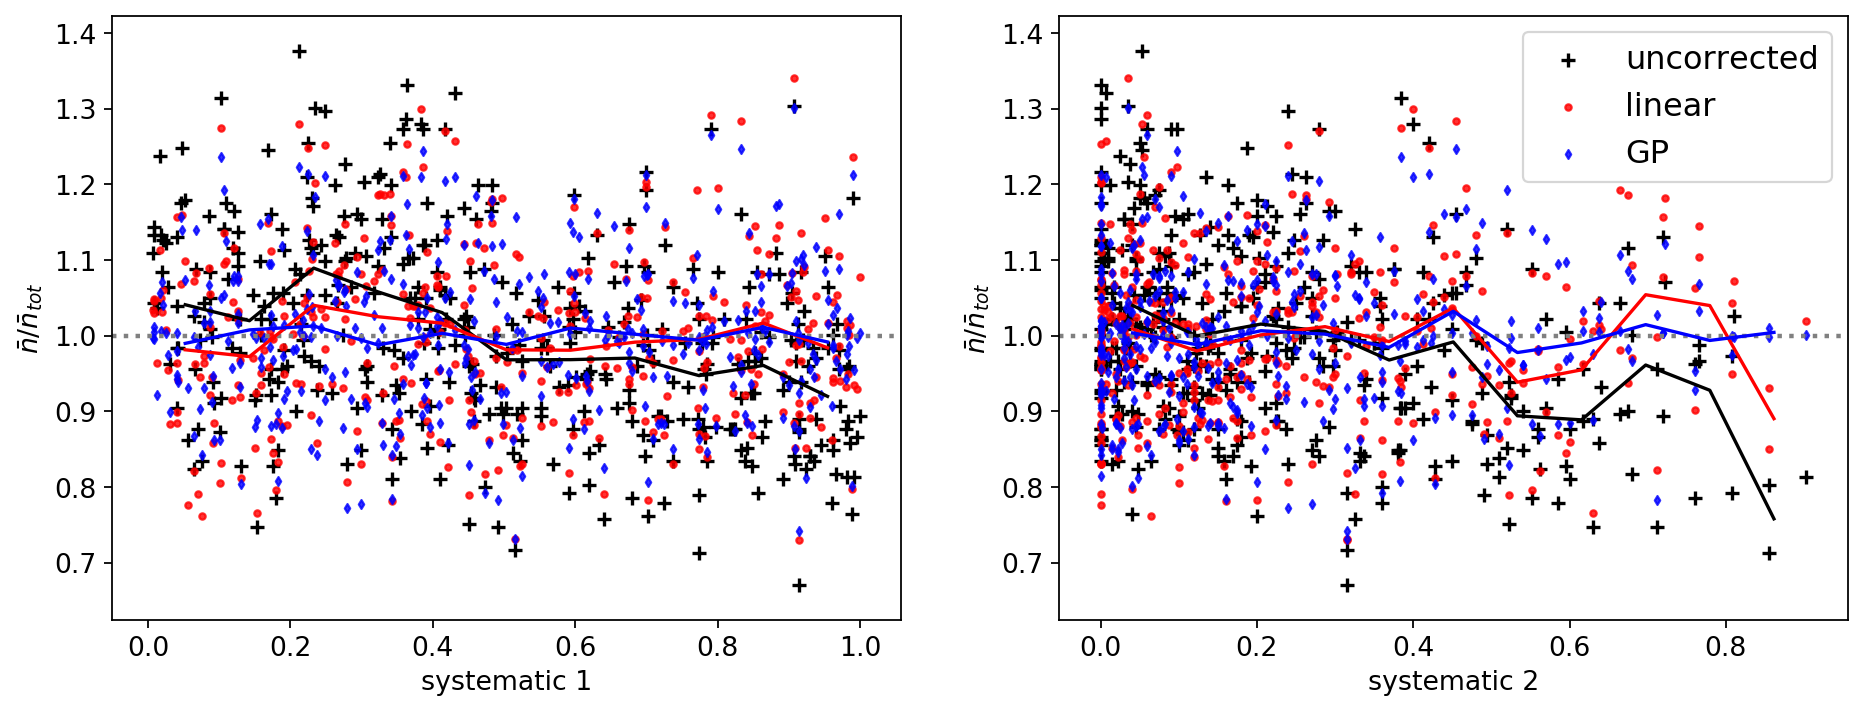

In [73]:
plot_nratio(lindf, res=res, gppred=gpp_lin)

### Downsample - nonlinear

In [61]:
def cubic(x):
    return 1.4-12*((0.8*x-0.33))**3 

def jagged(x):
    xjag = []
    
    for xval in x:
        xx = 1-xval
        if xx<0.5:
            xjag.append(0.7+0.5*xx)
        elif 0.5<=xx<0.8:
            xjag.append(1.7-15*(xx-0.75)**2)
        else:
            xjag.append(0.8+xx)
    return np.array(xjag)

def turnoff(x):
    xt = []
    for xx in x:
        if xx<0.25:
            xt.append(1.2-0.5*xx)
        else:
            xt.append(0.8)
    return np.array(xt)

def zigzag(x):
    xt = []
    for xx in x:
        if xx<0.25:
            xt.append(1.25-2*xx)
        elif 0.25<=xx<0.5:
            xt.append(0.25+2*xx)
        elif 0.5<=xx<0.75:
            xt.append(2.25-2*xx)
        else:
            xt.append(-0.75+2*xx)
    return np.array(xt)

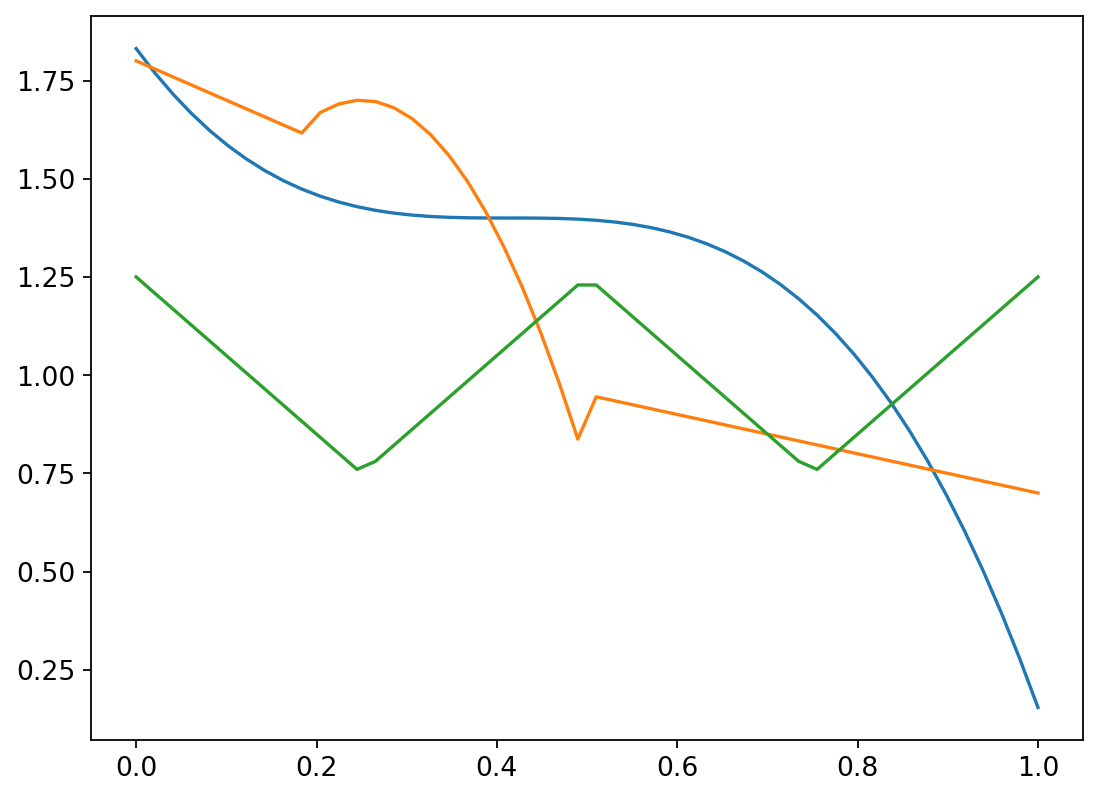

In [62]:
x = np.linspace(0, 1)
plt.plot(x, cubic(x))
plt.plot(x, jagged(x))
plt.plot(x, zigzag(x))

In [63]:
def downsample_nonlin(ddf, sn0, sn1, sn01, downfunc0, downfunc1, downfunc01):
    sel = np.array([np.random.random() for _ in range(len(ddf))])
    ww = downfunc0(ddf[sn0])
    subdf = ddf[(sel < ww)]
    
    sel = np.array([np.random.random() for _ in range(len(subdf))])
    ww = downfunc1(subdf[sn1])
    subdf = subdf[sel < ww]
    
#     sel = np.array([np.random.random() for _ in range(len(subdf))])
#     ww = downfunc01(subdf[sn01])
#     subdf = subdf[sel < ww]
    
    return subdf

In [64]:
#datadf['s01'] = 0.3*datadf['s0']+0.3*datadf['s1'] + 0.4*datadf['s0']*datadf['s1']
datadf['s01'] = normalize(datadf['s0']*datadf['s1'])
cubdf = downsample_nonlin(datadf, 's0', 's1', 's01', downfunc0=zigzag, downfunc1=jagged, downfunc01=cubic)
print(len(cubdf)/len(datadf))

0.923011804171018


In [65]:
#datadf['s01'] = 0.3*datadf['s0']+0.3*datadf['s1'] + 0.4*datadf['s0']*datadf['s1']
# datadf['s01'] = 0.5*datadf['s0']+0.5*datadf['s1']
# cubdf = downsample(datadf, 's01', downfunc=cubic)
# print(len(cubdf)/len(datadf))

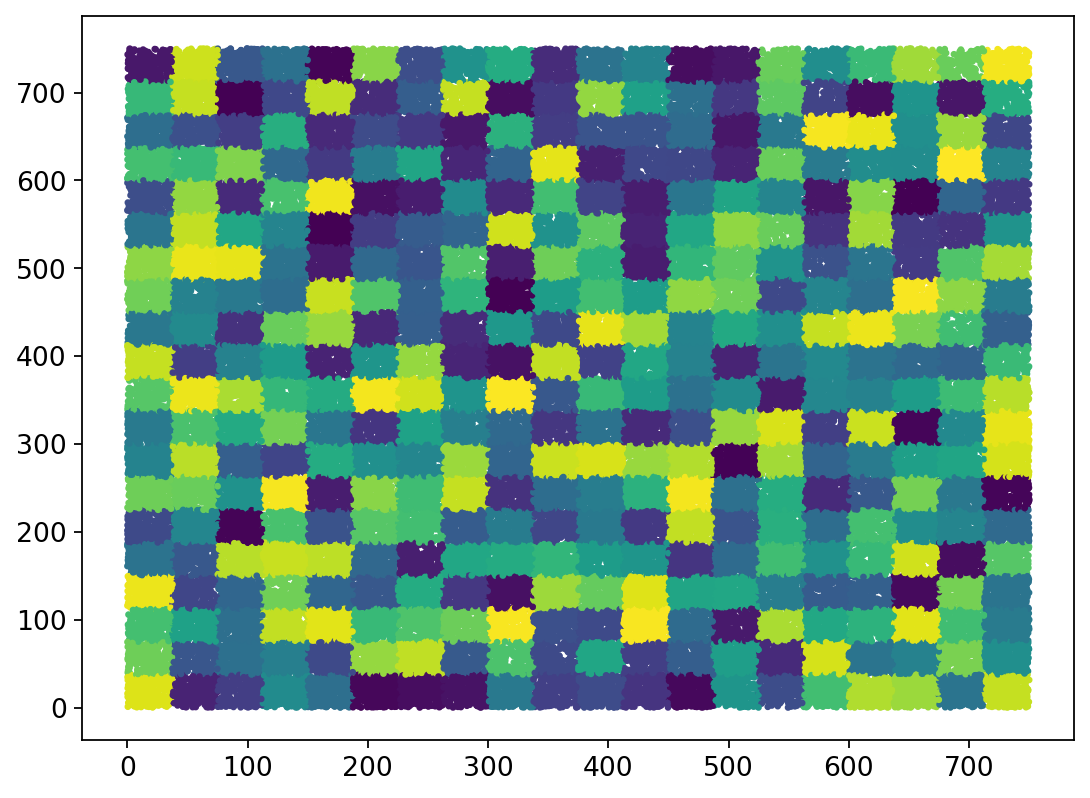

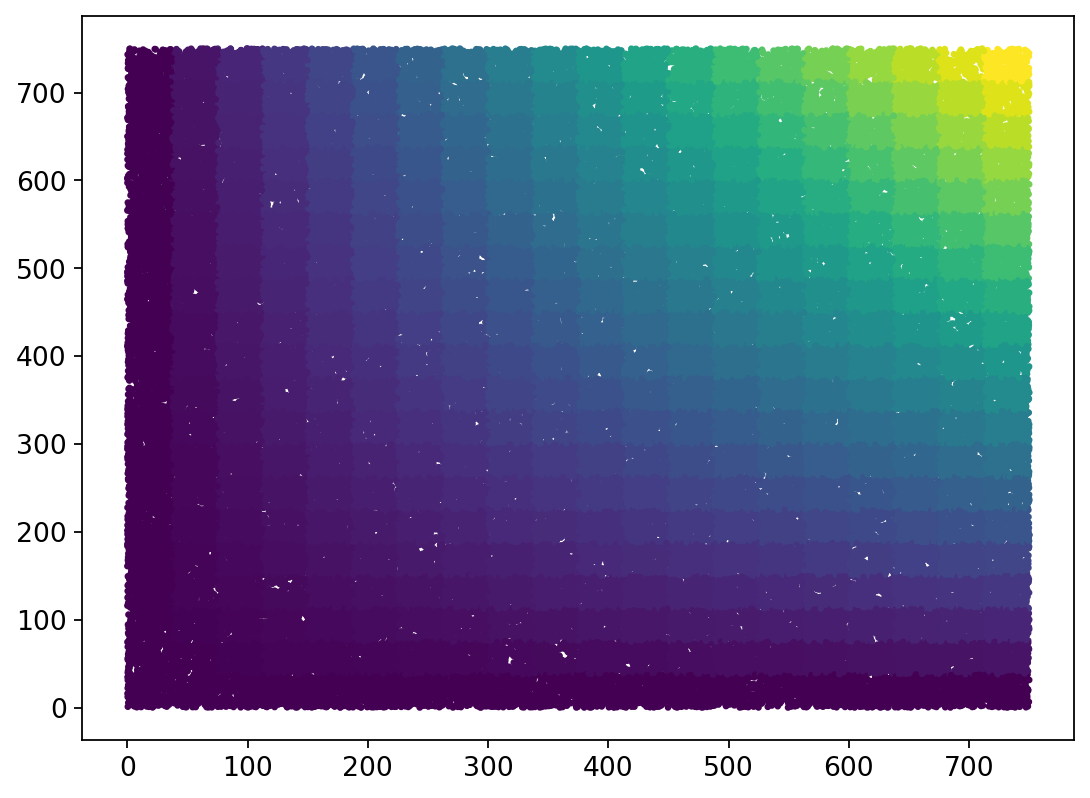

In [66]:
plt.figure()
plt.scatter(cubdf['x'], cubdf['y'], s=4, c=cubdf['s0'])
plt.figure()
plt.scatter(cubdf['x'], cubdf['y'], s=4, c=cubdf['s1'])

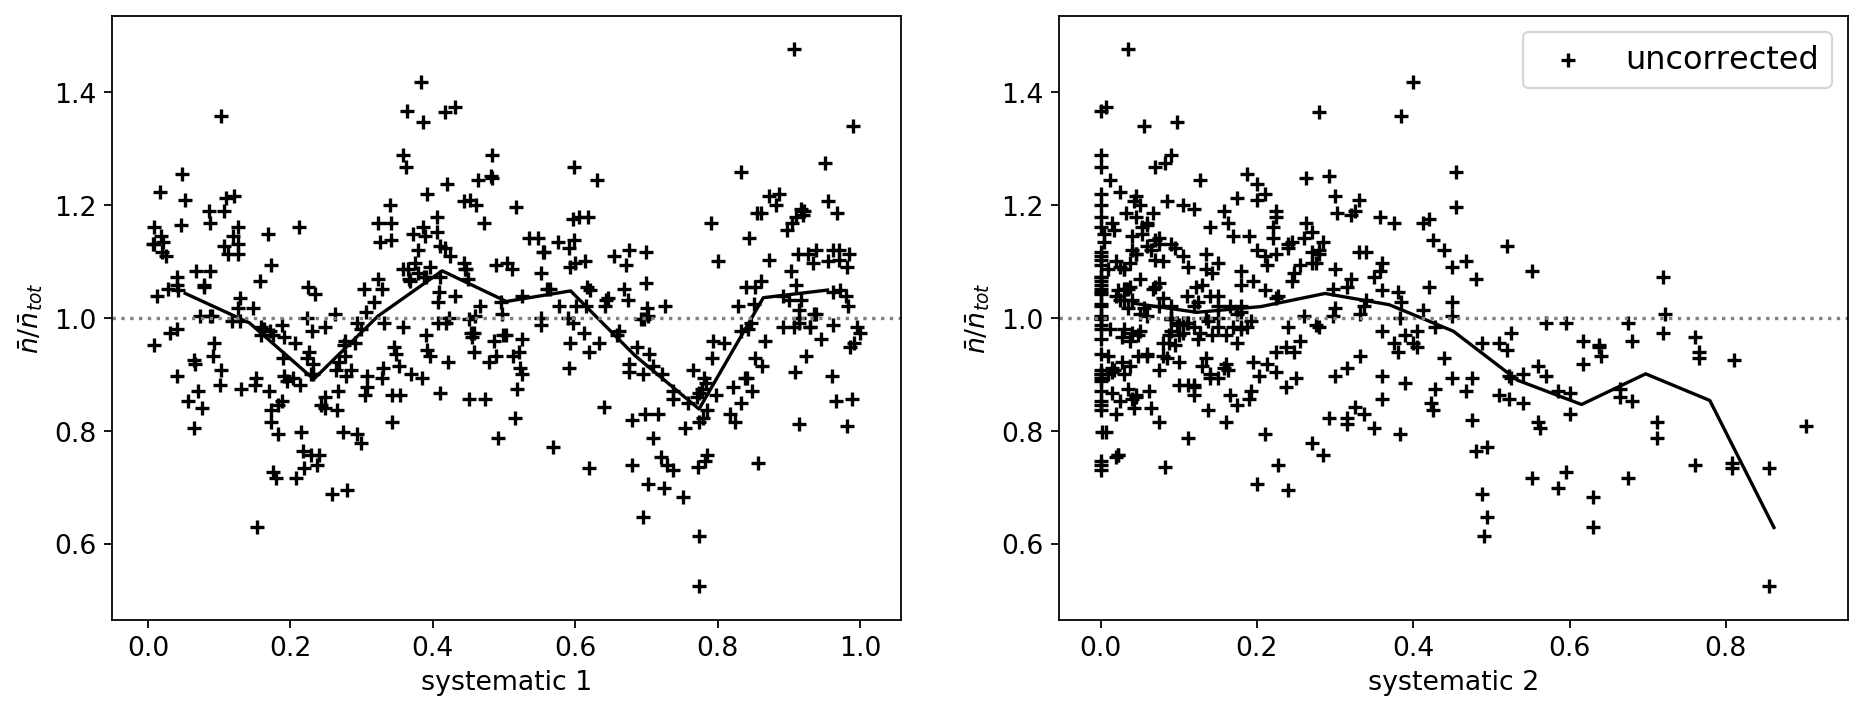

In [67]:
plot_nratio(cubdf)

In [68]:
guess = [0]*nsys + [1]
print(guess)
args = (mask, cubdf, smeans, sstds)
rescub = optimize.minimize(linear_fit, guess, args=args)
#print(rescub)
print(rescub.x)

[0, 0, 1]
[-6.57698428e-05 -4.52501069e-02  9.99999992e-01]


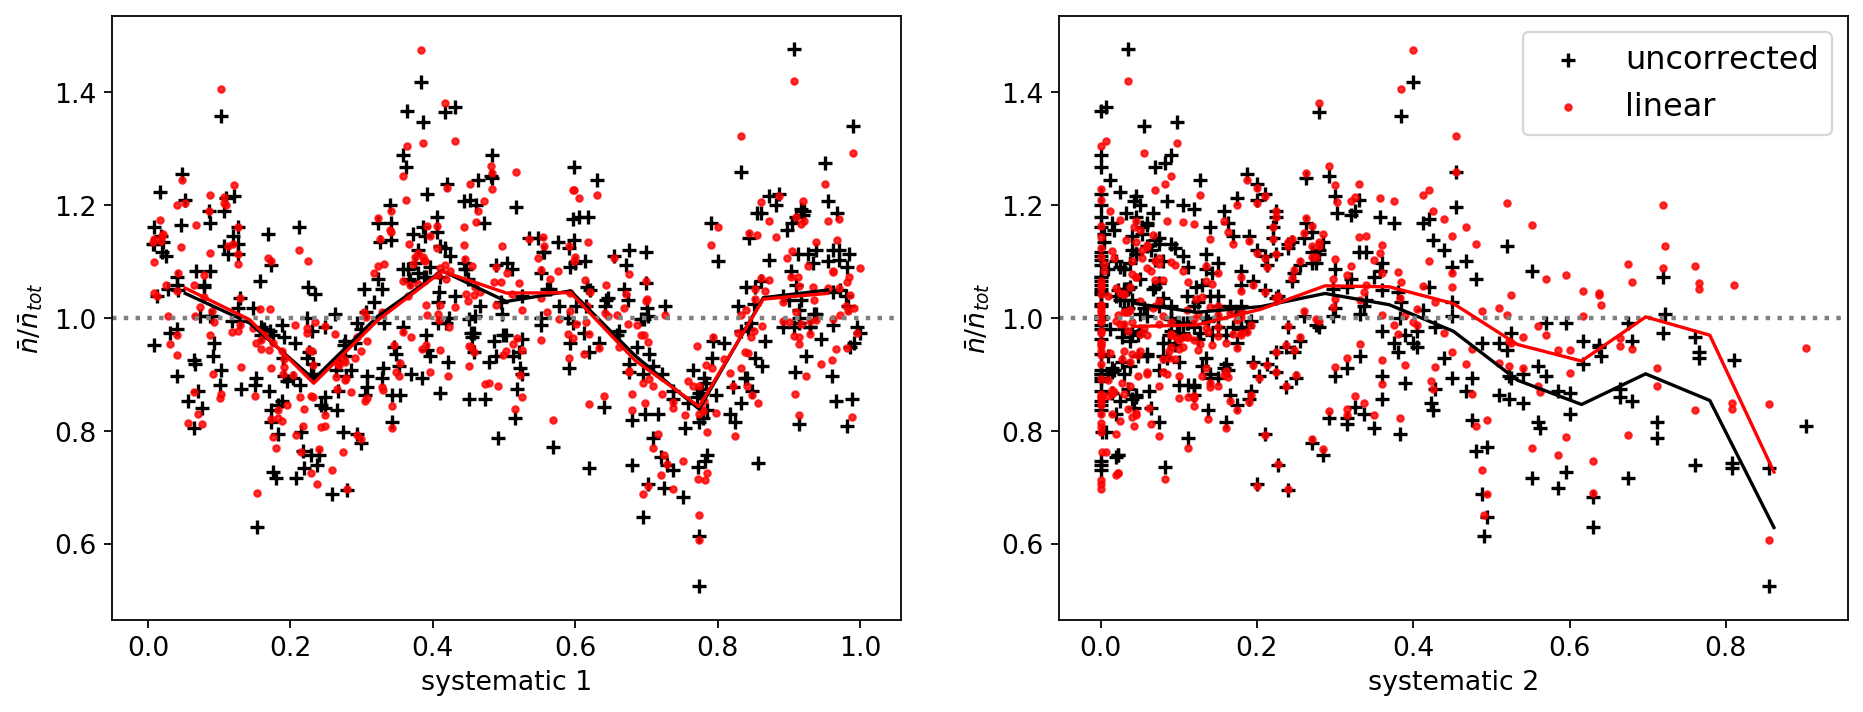

In [74]:
plot_nratio(cubdf, res=rescub)

In [ ]:
# def correct_gp(bins, gal2rand):

#     kernel = kernels.ExpSquaredKernel(1.0)
#     gp = george.GP(kernel)
    
#     gp.compute()
    
#     def corrfit(x):
#         pred, _ = gp.predict(gal2rand, x)
#         return pred
    
#     return corrfit

In [75]:
def gp_fit(mask, df, smeans, sstds):

    nk = len(smeans)

    
    p0 = np.full(nk, 0.5)
    kernel0 = kernels.ExpSquaredKernel(p0, ndim=len(p0))
    #kernel1 = kernels.Matern32Kernel(p0, ndim=len(p0))
    #kernel2 = kernels.ConstantKernel(0.1, ndim=len(p0))
    kernel = kernel0
    gp = george.GP(kernel)
    
    nbartot = len(df)/(boxsize**2)
    
    scorrs = np.zeros((npixside*npixside, nk))
    pixcount = 0
    nratios = np.zeros(npixside*npixside)
    for i in range(npixside):
        for j in range(npixside):
            
            ngal = len(df[(df['maski']==i) & (df['maskj']==j)])
            nbar = ngal/pixarea
            nratio = nbar/nbartot
            nratios[pixcount] = nratio
            for k in range(nk):
                s = mask[k, i, j]
                #scorr = (s - smeans[k])/sstds[k]
                scorrs[pixcount][k] = s
                
            pixcount += 1
    print(scorrs.shape)
    gp.compute(scorrs)
    def gppred(sarr):
        #sarrcorr = (s - smeans)/sstds
        pred, _ = gp.predict(nratios, sarr)
        return pred

    return gppred

In [76]:
#nsys = 2
#gpp = gp_fit(mask, cubdf, [smeans[0]], [sstds[0]])
gpp = gp_fit(mask, cubdf, smeans, sstds)

(400, 2)


In [414]:
# sarr = np.array(mask).reshape(-1,mask.shape[0])
# print(sarr.shape)
# pred = gpp(sarr)

In [415]:
# scont0 = np.linspace(0,1)
# #scont1 = np.full(len(scont0), 0.5)
# #scont = np.array([scont0,scont1]).T
# pred = gpp(scont0)
# plt.plot(scont0, pred)

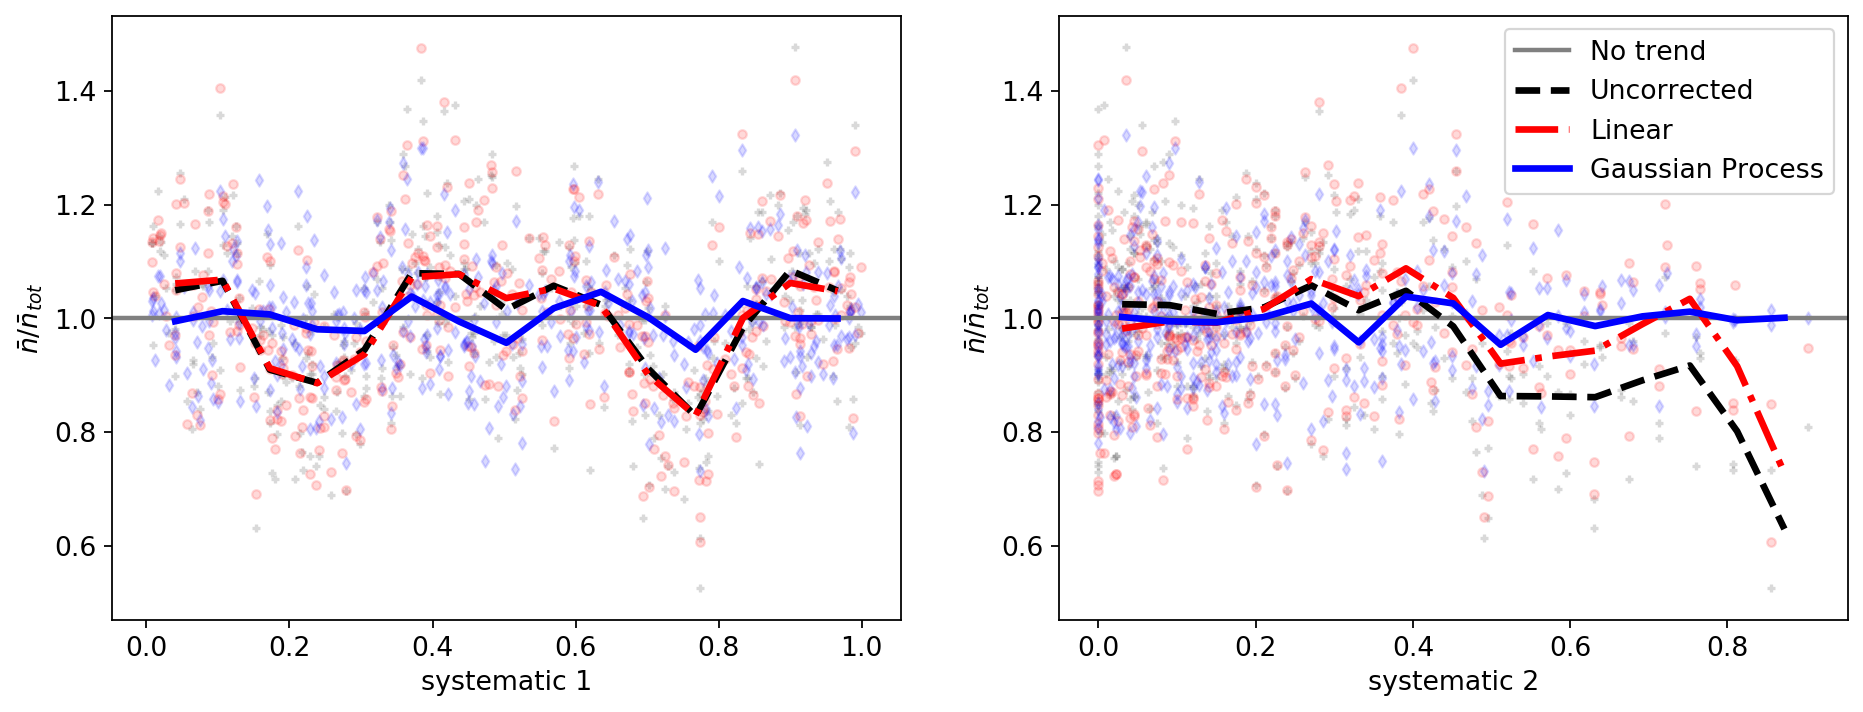

In [125]:
plot_nratio(cubdf, gppred=gpp, res=rescub)